In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
data=pd.read_csv("Google_Stock_Price_Train.csv")
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,357.385559,361.151062,355.959839,359.288177,359.288177,5115500
1,2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4666500
2,2013-01-04,362.313507,368.339294,361.488861,366.600616,366.600616,5562800
3,2013-01-07,365.348755,367.301056,362.929504,365.001007,365.001007,3332900
4,2013-01-08,365.393463,365.771027,359.874359,364.280701,364.280701,3373900
...,...,...,...,...,...,...,...
1379,2018-06-25,1143.599976,1143.910034,1112.780029,1124.810059,1124.810059,2157300
1380,2018-06-26,1128.000000,1133.209961,1116.659058,1118.459961,1118.459961,1563200
1381,2018-06-27,1121.339966,1131.836060,1103.619995,1103.979980,1103.979980,1293900
1382,2018-06-28,1102.089966,1122.310059,1096.010010,1114.219971,1114.219971,1072400


In [6]:
#training (first 1260 rows) and testing sets.
train = data.iloc[:1260,:]
test = data.iloc[1260:,:]

In [7]:
train

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,357.385559,361.151062,355.959839,359.288177,359.288177,5115500
1,2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4666500
2,2013-01-04,362.313507,368.339294,361.488861,366.600616,366.600616,5562800
3,2013-01-07,365.348755,367.301056,362.929504,365.001007,365.001007,3332900
4,2013-01-08,365.393463,365.771027,359.874359,364.280701,364.280701,3373900
...,...,...,...,...,...,...,...
1255,2017-12-26,1058.069946,1060.119995,1050.199951,1056.739990,1056.739990,760600
1256,2017-12-27,1057.390015,1058.369995,1048.050049,1049.369995,1049.369995,1271900
1257,2017-12-28,1051.599976,1054.750000,1044.770020,1048.140015,1048.140015,837100
1258,2017-12-29,1046.719971,1049.699951,1044.900024,1046.400024,1046.400024,887500


In [8]:
#Extracts only the 'Open' column for training
trainset = train.iloc[:,1:2].values

In [9]:
trainset

array([[ 357.385559],
       [ 360.122742],
       [ 362.313507],
       ...,
       [1051.599976],
       [1046.719971],
       [1048.339966]])

In [10]:
#Scales the "Open" prices to a [0, 1] range to help the LSTM model converge faster.
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
training_scaled = sc.fit_transform(trainset)

In [11]:
training_scaled

array([[0.01011148],
       [0.01388614],
       [0.01690727],
       ...,
       [0.9674549 ],
       [0.96072522],
       [0.96295924]])

In [12]:
x_train = []
y_train = []

In [13]:
#sliding window of 60 time steps to predict the next price.
#For each point i, it takes the 60 previous days as input (x_train) and the current day as output (y_train).
for i in range(60,1125):
    x_train.append(training_scaled[i-60:i, 0])
    y_train.append(training_scaled[i,0])
x_train,y_train = np.array(x_train),np.array(y_train)

In [14]:
x_train.shape

(1065, 60)

In [15]:
#Reshapes input to 3D as required by Keras LSTM: (samples, timesteps, features)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [17]:
#4 stacked LSTM layers with 50 units each Capturing Long-Term Dependencies
#Dropout layers (20%) added for regularization (reduces overfitting)
#Final Dense layer outputs a single value (predicted price)
model = Sequential()
model.add(LSTM(units = 50,return_sequences = True,input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50,return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50,return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
#This setup will allow your model to use Adam for optimization, minimize the MSE loss during training,
#and track the MAE during evaluation.
model.compile(optimizer = 'adam',loss = 'mse', metrics = ['mae'])

In [19]:
#The model is trained for 100 epochs with a batch size of 32
history = model.fit(x_train,y_train,epochs = 100, batch_size = 32)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - loss: 0.0420 - mae: 0.1487
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 0.0038 - mae: 0.0468
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 0.0032 - mae: 0.0434
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - loss: 0.0029 - mae: 0.0405
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0031 - mae: 0.0426
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - loss: 0.0038 - mae: 0.0468
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - loss: 0.0026 - mae: 0.0376
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 0.0032 - mae: 0.0432
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - loss: 0.0024 - mae: 0.0363
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - loss: 0.0029 - mae: 0.0392
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0025 - mae: 0.0375
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 0.0027 - mae: 0.0374
Epoch 13/100

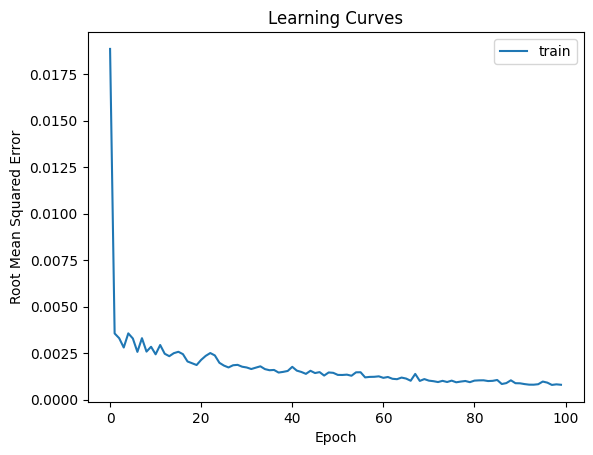

In [20]:
from matplotlib import pyplot
# plot learning curves
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Root Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

In [21]:
test

,Date,Open,High,Low,Close,Adj Close,Volume
1260,2018-01-03,1064.310059,1086.290039,1063.209961,1082.479980,1082.479980,1430200
1261,2018-01-04,1088.000000,1093.569946,1084.001953,1086.400024,1086.400024,1004600
1262,2018-01-05,1094.000000,1104.250000,1092.000000,1102.229980,1102.229980,1279100
1263,2018-01-08,1102.229980,1111.270020,1101.619995,1106.939941,1106.939941,1047600
1264,2018-01-09,1109.400024,1110.569946,1101.230957,1106.260010,1106.260010,902500
...,...,...,...,...,...,...,...
1379,2018-06-25,1143.599976,1143.910034,1112.780029,1124.810059,1124.810059,2157300
1380,2018-06-26,1128.000000,1133.209961,1116.659058,1118.459961,1118.459961,1563200
1381,2018-06-27,1121.339966,1131.836060,1103.619995,1103.979980,1103.979980,1293900
1382,2018-06-28,1102.089966,1122.310059,1096.010010,1114.219971,1114.219971,1072400


In [22]:
#Extracts the actual 'Open' prices from the test set.
real_stock_price = test.iloc[:,1:2].values

In [23]:

dataset_total = pd.concat((train['Open'],test['Open']),axis = 0)
dataset_total

,Open
0,357.385559
1,360.122742
2,362.313507
3,365.348755
4,365.393463
...,...
1379,1143.599976
1380,1128.000000
1381,1121.339966
1382,1102.089966


In [24]:
##Combines train and test data.
#Selects the last 60 days before the test set + test set to make predictions.
inputs = dataset_total[len(dataset_total) - len(test)-60:].values
inputs

array([ 966.700012,  980.      ,  980.      ,  973.719971,  987.450012,
        992.      ,  992.099976,  990.289978,  991.77002 ,  986.      ,
        989.440002,  989.52002 ,  970.      ,  968.369995,  980.      ,
       1009.190002, 1014.      , 1015.219971, 1017.210022, 1021.76001 ,
       1022.109985, 1028.98999 , 1027.27002 , 1030.52002 , 1033.98999 ,
       1026.459961, 1023.419983, 1022.590027, 1019.210022, 1022.52002 ,
       1034.01001 , 1020.26001 , 1023.309998, 1035.      , 1035.869995,
       1040.      , 1055.089966, 1042.680054, 1022.369995, 1015.799988,
       1012.659973,  995.940002, 1001.5     , 1020.429993, 1037.48999 ,
       1035.5     , 1039.630005, 1046.119995, 1045.      , 1054.609985,
       1066.079956, 1075.199951, 1071.780029, 1064.949951, 1061.109985,
       1058.069946, 1057.390015, 1051.599976, 1046.719971, 1048.339966,
       1064.310059, 1088.      , 1094.      , 1102.22998 , 1109.400024,
       1097.099976, 1106.300049, 1102.410034, 1132.51001 , 1126.

In [25]:
inputs = inputs.reshape(-1,1)

In [26]:
inputs

array([[ 966.700012],
       [ 980.      ],
       [ 980.      ],
       [ 973.719971],
       [ 987.450012],
       [ 992.      ],
       [ 992.099976],
       [ 990.289978],
       [ 991.77002 ],
       [ 986.      ],
       [ 989.440002],
       [ 989.52002 ],
       [ 970.      ],
       [ 968.369995],
       [ 980.      ],
       [1009.190002],
       [1014.      ],
       [1015.219971],
       [1017.210022],
       [1021.76001 ],
       [1022.109985],
       [1028.98999 ],
       [1027.27002 ],
       [1030.52002 ],
       [1033.98999 ],
       [1026.459961],
       [1023.419983],
       [1022.590027],
       [1019.210022],
       [1022.52002 ],
       [1034.01001 ],
       [1020.26001 ],
       [1023.309998],
       [1035.      ],
       [1035.869995],
       [1040.      ],
       [1055.089966],
       [1042.680054],
       [1022.369995],
       [1015.799988],
       [1012.659973],
       [ 995.940002],
       [1001.5     ],
       [1020.429993],
       [1037.48999 ],
       [10

In [27]:
inputs = sc.transform(inputs)
inputs.shape

(184, 1)

In [28]:
#Creates sequences of 60 previous prices for each prediction point, just like in training.
x_test = []
for i in range(60,185):
    x_test.append(inputs[i-60:i,0])

In [29]:
x_test = np.array(x_test)
x_test.shape

(125, 60)

In [30]:
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
x_test.shape

(125, 60, 1)

In [31]:
predicted_price = model.predict(x_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step


In [32]:
predicted_price = sc.inverse_transform(predicted_price)
predicted_price

array([[1053.8068],
       [1056.8202],
       [1066.7568],
       [1079.1841],
       [1090.4218],
       [1098.9365],
       [1101.0692],
       [1100.9147],
       [1099.6609],
       [1104.7996],
       [1111.8434],
       [1118.539 ],
       [1123.2784],
       [1127.005 ],
       [1134.3015],
       [1145.9406],
       [1155.7157],
       [1161.7615],
       [1164.6686],
       [1163.8723],
       [1162.3865],
       [1160.1392],
       [1150.2206],
       [1132.3978],
       [1103.351 ],
       [1085.9834],
       [1078.0739],
       [1068.9999],
       [1065.4918],
       [1066.0768],
       [1068.5627],
       [1076.4332],
       [1086.8241],
       [1095.0085],
       [1101.9032],
       [1108.0768],
       [1111.3188],
       [1114.9397],
       [1121.1066],
       [1123.515 ],
       [1119.6348],
       [1102.7145],
       [1087.329 ],
       [1084.1538],
       [1088.0238],
       [1098.897 ],
       [1114.6359],
       [1133.8505],
       [1150.2418],
       [1154.359 ],


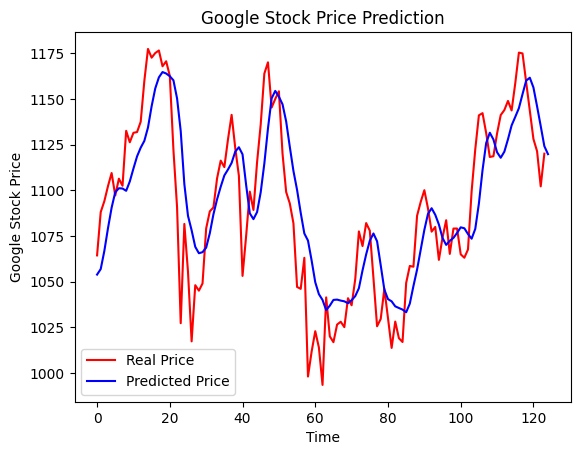

In [33]:
#Compares predicted vs actual stock prices visually.
plt.plot(real_stock_price,color = 'red', label = 'Real Price')
plt.plot(predicted_price, color = 'blue', label = 'Predicted Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()